## Step 6: Evaluate Ep300 knockout differential expression test results

Next, we examine the RNA-seq data for the Ep300 knockout experiments in Lee et al's Figure 2 (EAE) & Extended Data Figure 6 (NOD EAE). 

In [1]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(eulerr)
library(readxl)
library(ggrepel)
library(svglite)
library(ggrastr)
setwd('..') # change working directory to 'EpiMemAstros' folder


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




First, read in Supplementary Table 4, which contains the differential expression test results comparing the sgEp300 and sgScrmbl groups in the EAE model.

In [2]:
ep300_ko = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM5_ESM.xlsx')
ep300_ko[1:10,]

New names:
• `` -> `...8`
• `` -> `...9`


Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,...8,...9
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>
mt-Rnr2,92458.85,-0.15919007,0.1240199,-1.2835847,0.19928732,0.84628526,NA,NA
Ttr,57381.16,-0.06047555,0.1728371,-0.3498992,0.72641435,0.98580543,NA,NA
mt-Co1,26815.63,-0.27990302,0.1291410,-2.1674215,0.03020273,0.55979809,NA,NA
Enpp2,21352.66,-0.02370212,0.1983590,-0.1194910,0.90488637,0.99972023,NA,NA
Apoe,21209.36,-0.27928853,0.1390909,-2.0079576,0.04464780,0.62499340,NA,NA
Plp1,17722.90,-0.53912885,0.1376641,-3.9162640,0.00008990,0.03283709,NA,NA
mt-Nd1,17392.27,-0.23182347,0.1483621,-1.5625519,0.11815803,0.78190268,NA,NA
Hbb-bt,16024.13,-0.28846930,1.0913300,-0.2643282,0.79152702,0.99555331,NA,NA
mt-Cytb,14159.84,-0.25907477,0.1240344,-2.0887333,0.03673173,0.58738599,NA,NA


We next extract lists of genes which were differentially expressed between conditions (adjusted p-value < 0.05), both up- and down- regulated gene lists.

In [3]:
ep300_ko_up = ep300_ko %>% filter(padj < 0.05) %>% filter(log2FoldChange > 0) %>% .$Gene
ep300_ko_down = ep300_ko %>% filter(padj < 0.05) %>% filter(log2FoldChange < 0) %>% .$Gene

Now, read in the original Up- and Down-signature gene lists from Supplementary Table 3.

In [4]:
signature = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_genes = signature %>% filter(log2FoldChange > 0) %>% .$gene
down_genes = signature %>% filter(log2FoldChange < 0) %>% .$gene

Next, we'll examine the overlaps between the diffentially expressed genes in the Ep300 knockout compared to the Up- and Down-signature gene lists.

In [5]:
groups = list(up_genes, down_genes, ep300_ko_up, ep300_ko_down)
overlap_matrix = outer(groups, groups, FUN = Vectorize(function(x,y) length(intersect(x,y))))
overlap_matrix[lower.tri(overlap_matrix)] <- NA
overlaps <- na.omit(c(t(overlap_matrix)))
names(overlaps) <- c("Up-signature", "Up-signature&Down-signature", "Up-signature&Up in Ep300 cKO", "Up-signature&Down in Ep300 cKO", "Down-signature", "Down-signature&Up in Ep300 cKO", 'Down-signature&Down in Ep300 cKO', 
                      "Up in Ep300 cKO", 'Up in Ep300 cKO&Down in Ep300 cKO', 'Down in Ep300 cKO')

set.seed(6)
fit <- euler(overlaps,shape = "ellipse", input = 'union')

pdf 
  2

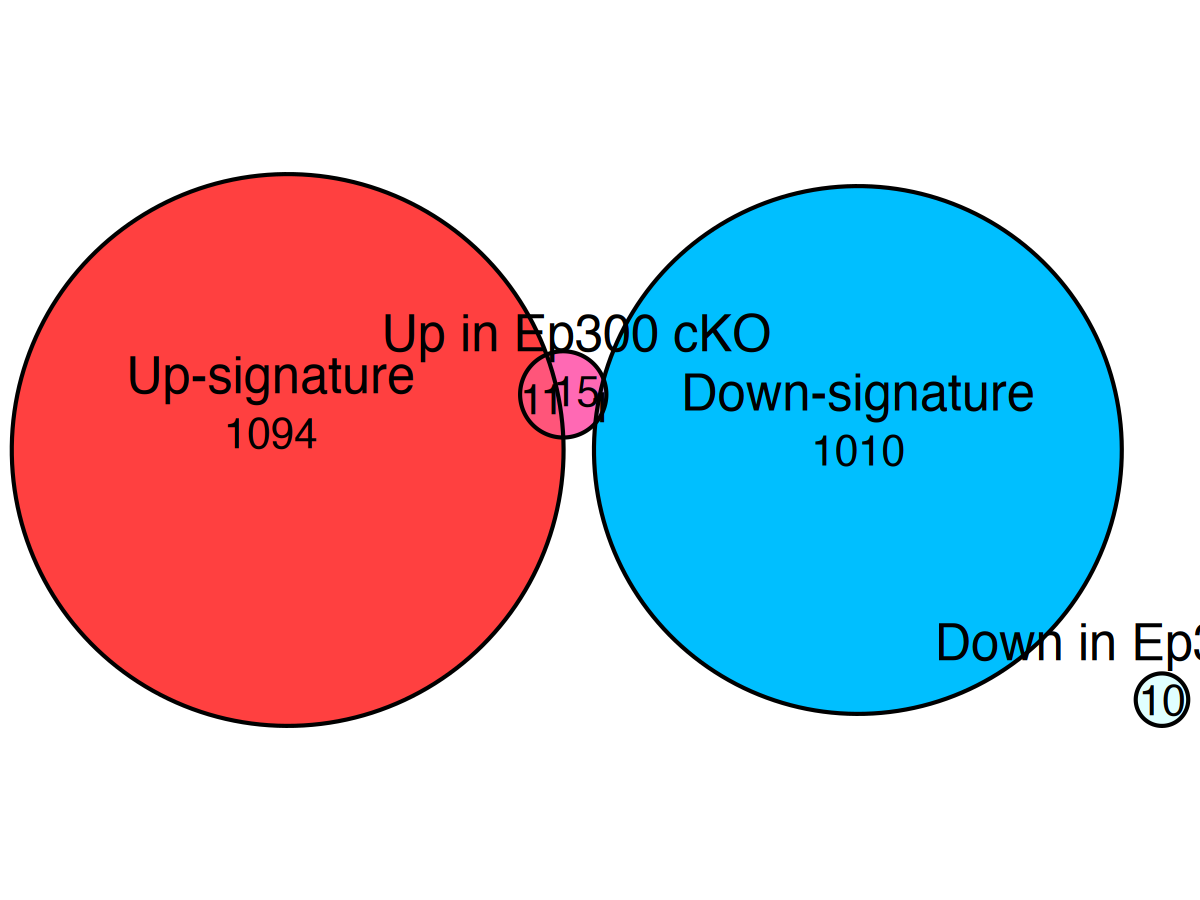

In [6]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)

image = plot(fit, quantities = FALSE, labels = FALSE, fill = c("brown1", "deepskyblue", "hotpink", "lightcyan"))

svglite("outputs/figures/figure2b.svg",width=4,height=3)
image
dev.off()

plot(fit, quantities = list(fontsize = 10), labels = list(fontsize = 12), fill = c("brown1", "deepskyblue", "hotpink", "lightcyan"))

We note that despite the appearance of the heatmap in Lee et al's Figure 2C, only 10 genes are significantly decreased in expression in the sgEp300 group compared to the sgScrmbl control. It further appears none of those down-regulated genes are members of the Up-signature gene set. 

We'll further examine the differential expression results in a volcano plot:

Warning message:
“Removed 10932 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 10932 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


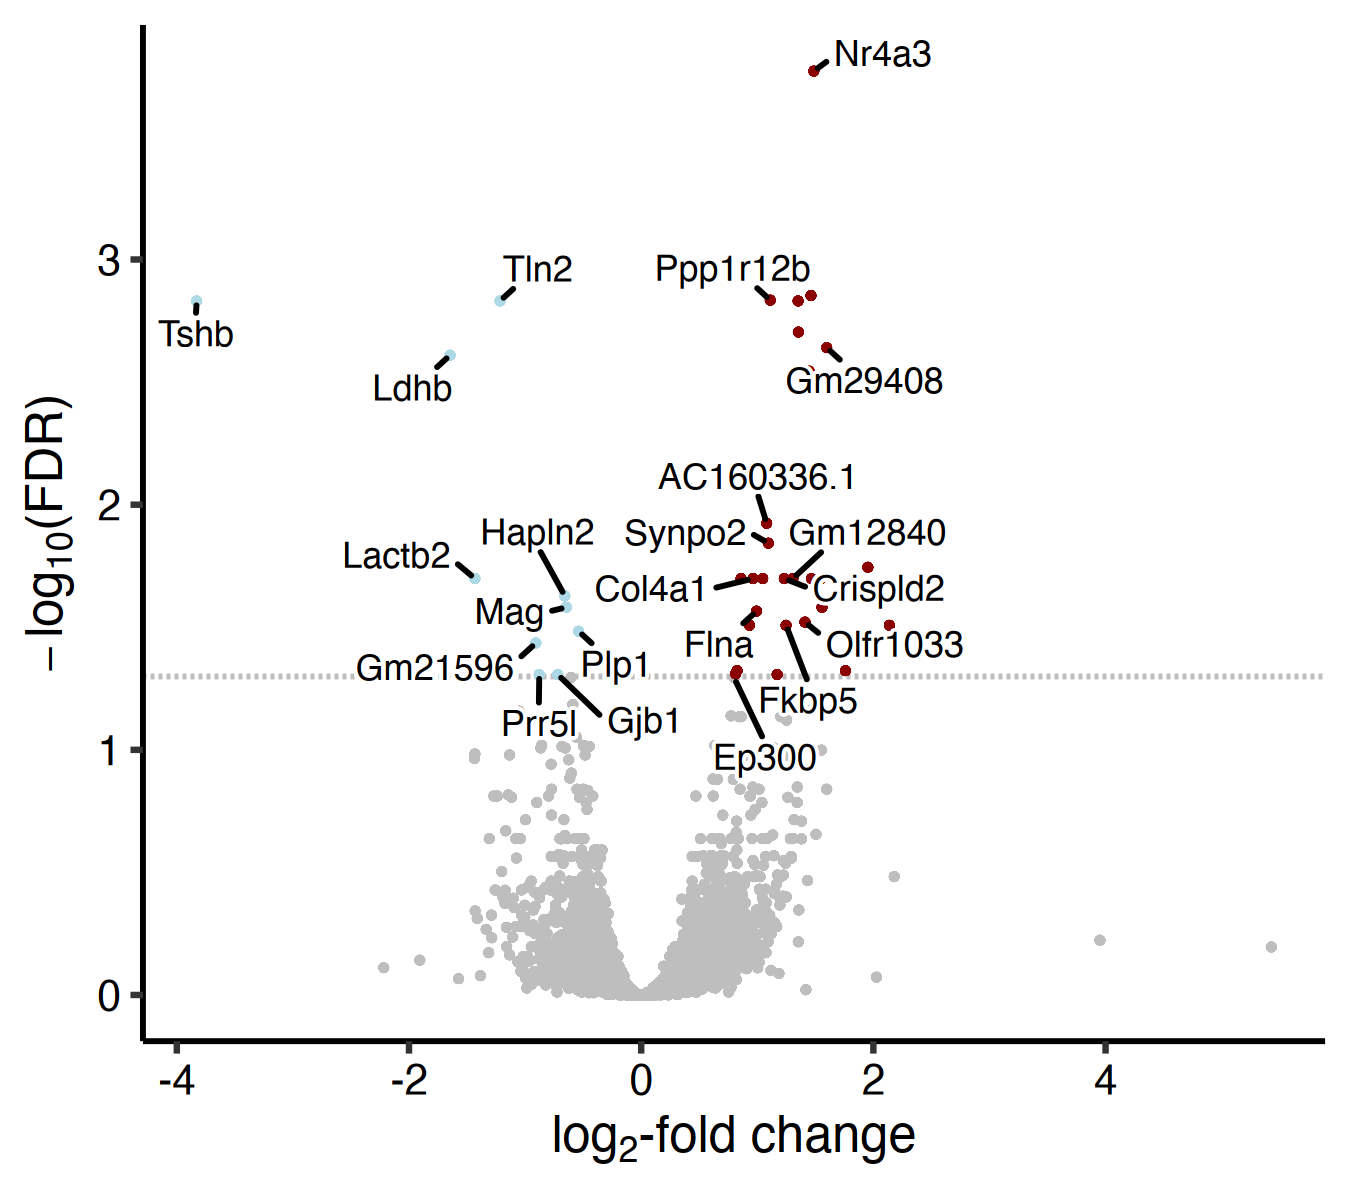

In [7]:
options(repr.plot.width=4.5, repr.plot.height=4, repr.plot.res = 300)

highlight_genes <- ep300_ko %>% filter(padj < 0.05) %>% filter(log2FoldChange < 0) %>% .$Gene

highlight_up_genes <- up_genes[up_genes %in% (ep300_ko %>% filter(padj < 0.05) %>% filter(log2FoldChange > 0) %>% .$Gene)]

highlight_genes <- c(highlight_genes, highlight_up_genes, 'Ep300')

image <- ggplot(data = ep300_ko %>% mutate(label = ifelse(Gene %in% highlight_genes, Gene, NA)) %>% 
                                                                         mutate(significance = ifelse((padj < 0.05) & (log2FoldChange > 0), "Up", 
                                                                                              ifelse((padj < 0.05) & (log2FoldChange < 0), "Down",
                                                                                                    "NS"))),
       aes(x = log2FoldChange, y = -log10(padj), label = label, color= significance)) + 
    geom_hline(yintercept = -log10(0.05), col = "gray", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.5), dpi = 1200) + 
    labs(x = expression(paste(log[2],"-fold change")), y = expression(paste(-log[10], "(FDR)"))) + 
scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 0, min.segment.length = 0, 
                    bg.color = "white",
                        fontface = 'italic',
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 12),
              axis.title.x = element_text(size=12),
      axis.text = element_text(size = 10)
            )

ggsave(file="outputs/figures/figure2a.svg", plot=image, width=4.5, height=4)

image

Next, we'll evaluate the RNA-seq data from the Ep300 knockout in NOD EAE experiment.

First, read in the data from Supplementary Table 8:

In [8]:
ep300_ko_NOD = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM9_ESM.xlsx', sheet = "p300 vs Scramble")
ep300_ko_NOD[1:10,]

Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CT010467.1,332245.06,2.0057705,0.6442406,3.1133872,0.0018495321,0.12006730
Ttr,119585.15,0.1401879,0.2652233,0.5285655,0.5971069322,0.91920159
Hba-a2,72741.94,2.6219659,0.6755735,3.8810964,0.0001039866,0.03471188
Hba-a1,68239.04,2.6413706,0.6916329,3.8190353,0.0001339746,0.03655003
Hbb-bs,63798.18,2.3386716,0.6191438,3.7772671,0.0001585587,0.03915843
mt-Rnr2,59354.86,-0.1234211,0.2782951,-0.4434902,0.6574111880,0.93601470
Enpp2,27209.65,-0.3522846,0.2509960,-1.4035469,0.1604538189,0.65166362
Hbb-bt,17462.57,2.1861376,0.5753089,3.7999369,0.0001447329,0.03761160
mt-Co1,15849.40,-0.4314759,0.3608115,-1.1958487,0.2317555950,0.72984866


Let's plot the differential expression test results in a volcano plot. This should recaptiulate the volcano plot showin in the authors' Extended Data Figure 6G. To do this, we'll highlight the same genes originally highlighted by the authors in this figure panel (and add Ep300 as well).

Warning message:
“Removed 14067 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 14067 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


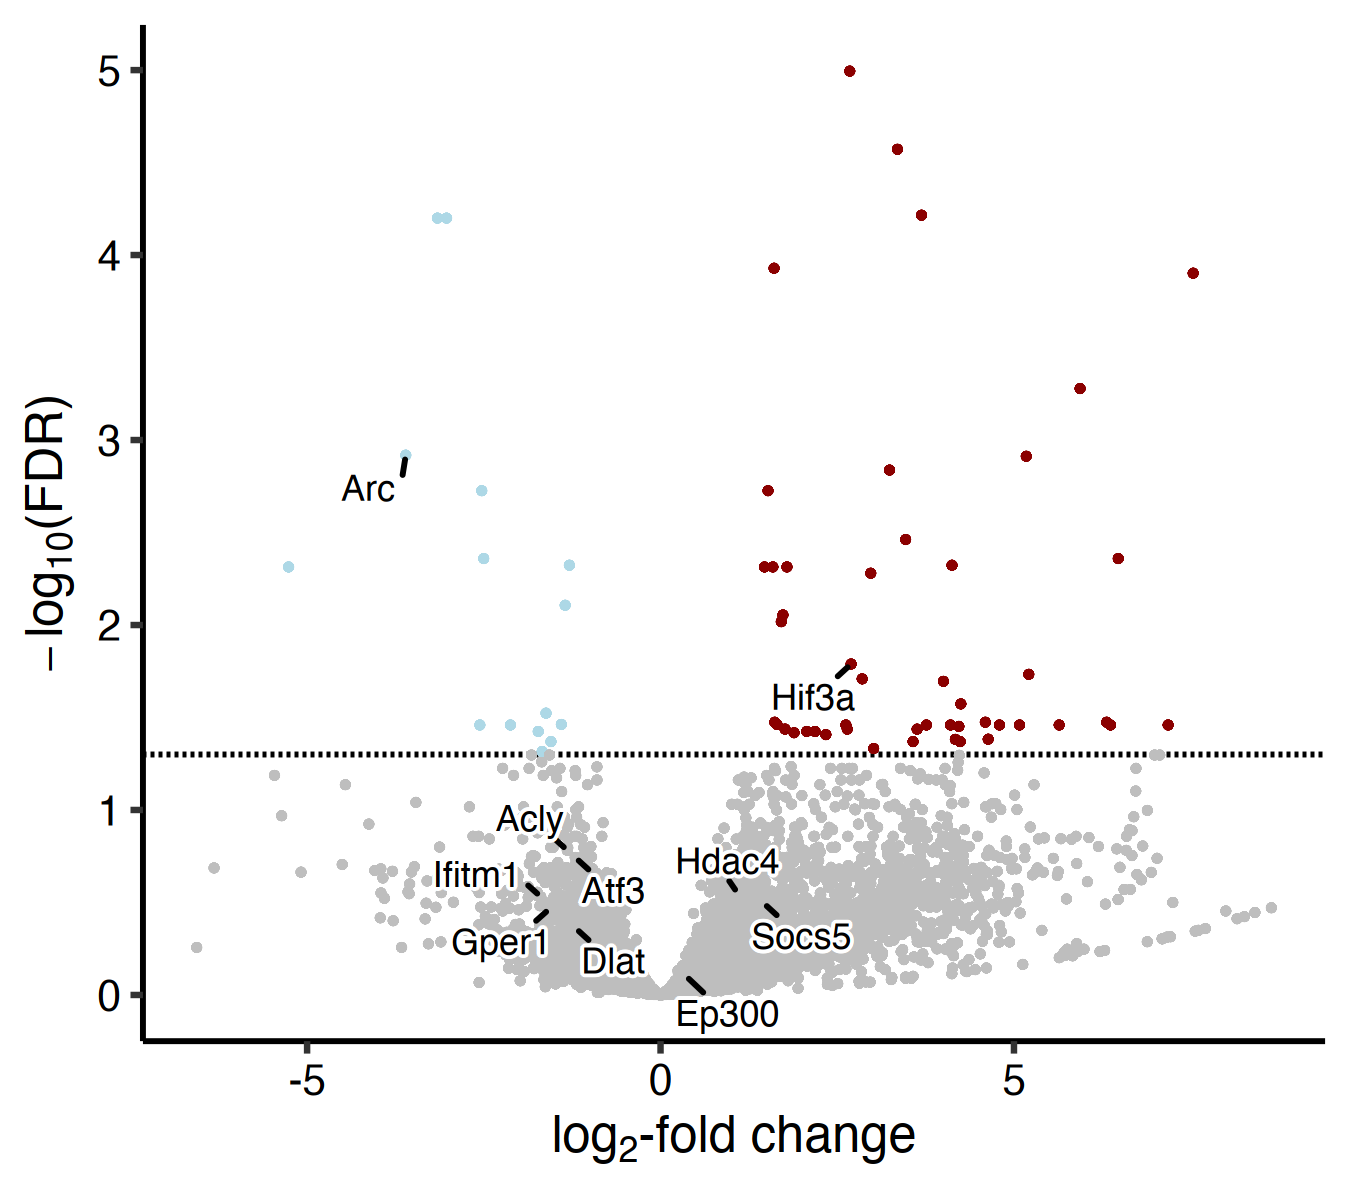

In [9]:
options(repr.plot.width=4.5, repr.plot.height=4, repr.plot.res = 300)

highlight_genes <- c('Arc', 'Acly', 'Atf3', 'Ifitm1', 'Gper1', 'Dlat', 
                    'Hdac4', 'Hif3a', 'Socs5', 
                    'Ep300')

image = ggplot(data = ep300_ko_NOD %>% mutate(label = ifelse(Gene %in% highlight_genes, Gene, NA)) %>% 
                                                                         mutate(significance = ifelse((padj < 0.05) & (log2FoldChange > 0), "Up", 
                                                                                              ifelse((padj < 0.05) & (log2FoldChange < 0), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FoldChange, y = -log10(padj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.5), dpi = 1200) + 
    labs(x = expression(paste(log[2],"-fold change")), y = expression(paste(-log[10], "(FDR)"))) + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                     fontface = 'italic',
                    min.segment.length = 0, 
                    bg.color = "white",
                     color = "black",
                     size =3,
                    bg.r = .15) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 12),
              axis.title.x = element_text(size=12),
                                          axis.text = element_text(size = 10)
            )

ggsave(file="outputs/figures/figure2d.svg", plot=image, width=4.5, height=4)

image

This volcano plot looks quite different from the original Extended Data Figure 6G plot. We can see that nearly all the genes originally highlighted by the authors are not significantly different when plotted with the multiple comparsisons adjusted p-value (a.k.a. FDR), except for Arc and Hif3a. We also note that Ep300 is not decreased in the sgEp300 condition as would be expected. 

What's the explanation for this discrepancy? Let's create the same volcano plot but use unadjusted p-values instead.

Warning message:
“Removed 14067 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


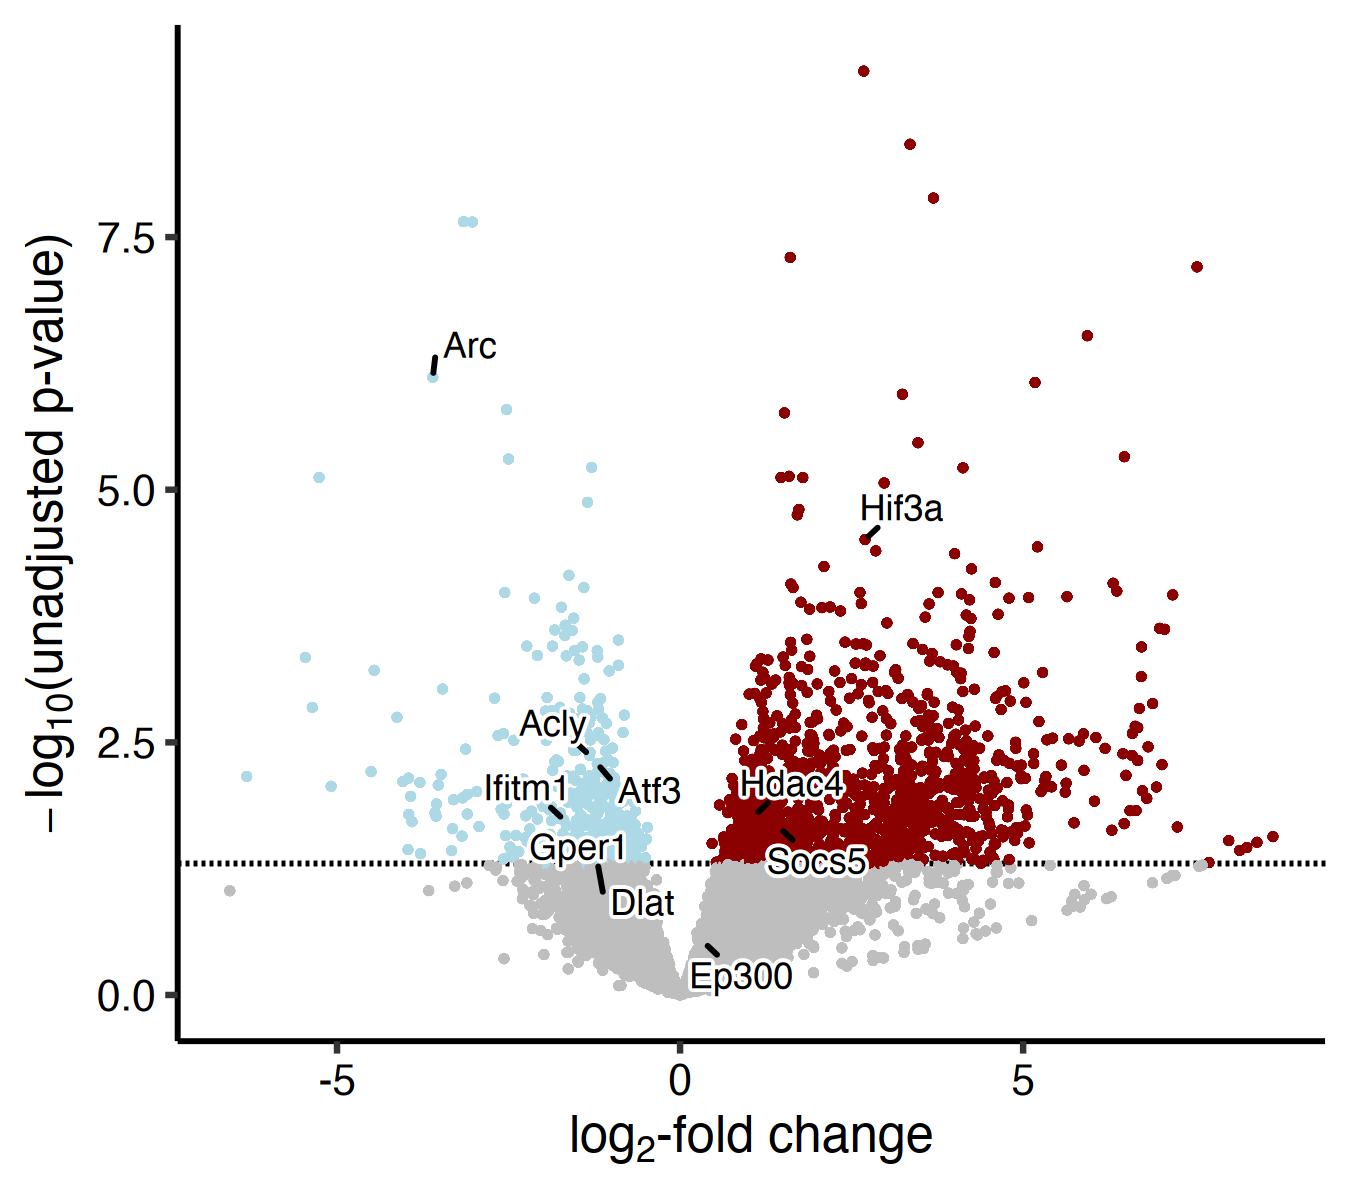

In [10]:
options(repr.plot.width=4.5, repr.plot.height=4, repr.plot.res = 300)

highlight_genes <- c('Arc', 'Acly', 'Atf3', 'Ifitm1', 'Gper1', 'Dlat', 
                    'Hdac4', 'Hif3a', 'Socs5', 
                    'Ep300')

ggplot(data = ep300_ko_NOD %>% mutate(label = ifelse(Gene %in% highlight_genes, Gene, NA)) %>% 
                                                                         mutate(significance = ifelse((pvalue < 0.05) & (log2FoldChange > 0), "Up", 
                                                                                              ifelse((pvalue < 0.05) & (log2FoldChange < 0), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FoldChange, y = -log10(pvalue), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.5), dpi = 1200) + 
    labs(x = expression(paste(log[2],"-fold change")), y = expression(paste(-log[10], "(unadjusted p-value)"))) + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    fontface = 'italic',
                     min.segment.length = 0, 
                    bg.color = "white",
                     color = "black",
                     size =3,
                    bg.r = .15) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 12),
              axis.title.x = element_text(size=12),
                                          axis.text = element_text(size = 10)
            )

This version of the plot appears much more similar to the original Extended Figure 6G panel. This suggests the likely explanation for the discrepancy here is the authors displayed the data using p-values not corrected for multiple comparisons. 

In this case this gives the impression that many genes are decreased in expression in the sgEp300 condition while only 15 genes genes are significantly decreased.

Next, we'll compare the overlap between the up- and down- signature gene sets and this experiment's differentially expressed genes.

In [11]:
ep300_ko_NOD_up = ep300_ko_NOD %>% filter(padj < 0.05) %>% filter(log2FoldChange > 0) %>% .$Gene
ep300_ko_NOD_down = ep300_ko_NOD %>% filter(padj < 0.05) %>% filter(log2FoldChange < 0) %>% .$Gene
groups = list(up_genes, down_genes, ep300_ko_NOD_up, ep300_ko_NOD_down)
overlap_matrix = outer(groups, groups, FUN = Vectorize(function(x,y) length(intersect(x,y))))
overlap_matrix[lower.tri(overlap_matrix)] <- NA
overlaps <- na.omit(c(t(overlap_matrix))) 
names(overlaps) <- c("Up-signature", "Up-signature&Down-signature", "Up-signature&Up in Ep300 cKO", "Up-signature&Down in Ep300 cKO", "Down-signature", "Down-signature&Up in Ep300 cKO", 'Down-signature&Down in Ep300 cKO', 
                      "Up in Ep300 cKO", 'Up in Ep300 cKO&Down in Ep300 cKO', 'Down in Ep300 cKO')
set.seed(11)
fit <- euler(overlaps,shape = "ellipse", input='union')

pdf 
  2

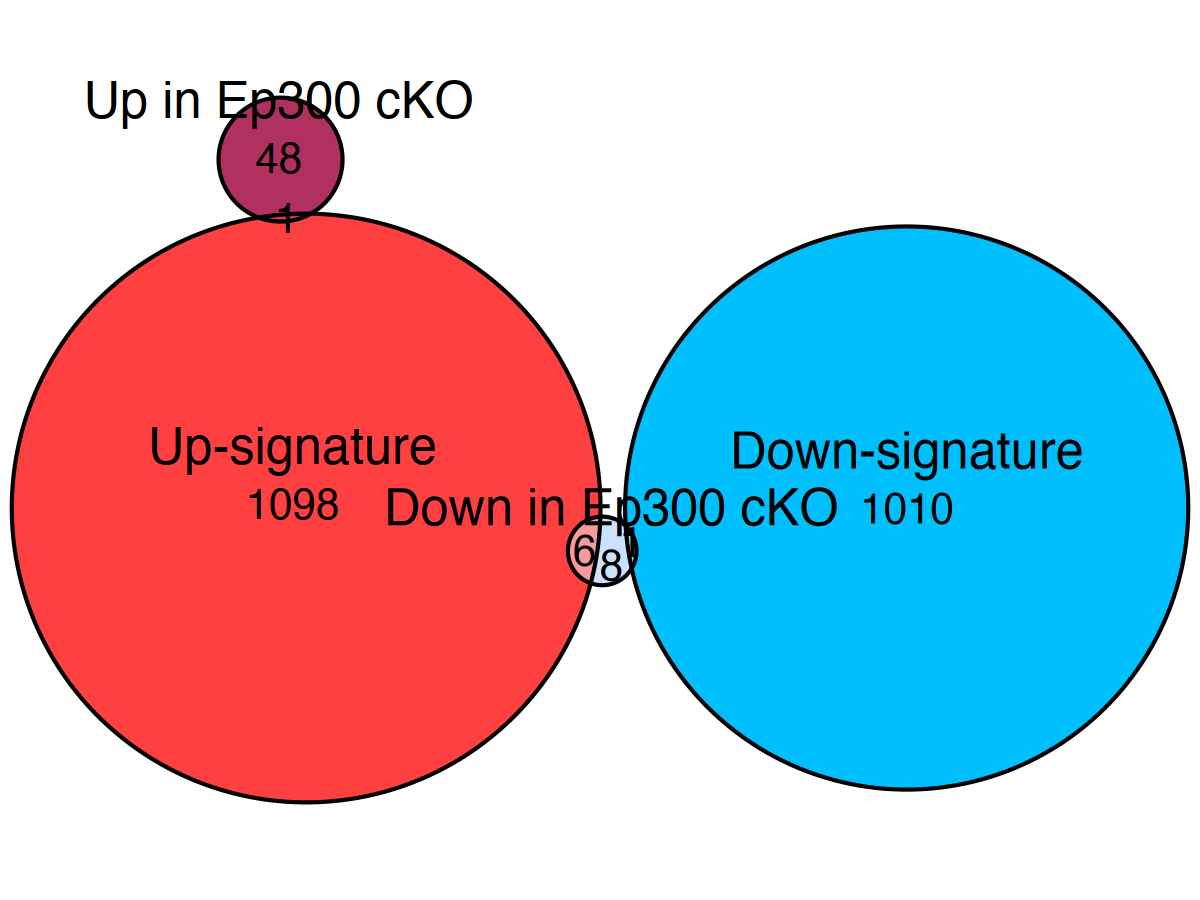

In [12]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)

image = plot(fit, quantities = FALSE, labels = FALSE, fill = c("brown1", "deepskyblue", 'maroon', 'lightsteelblue1'))

svglite("outputs/figures/figure2e.svg",width=4,height=3)
image
dev.off()

plot(fit, quantities = list(fontsize = 10), labels = list(fontsize = 12), fill = c("brown1", "deepskyblue", 'maroon', 'lightsteelblue1'))

Lastly, we'll compare the differentially expressed genes between the two experiments (EAE vs NOD EAE).

In [13]:
groups = list(ep300_ko_up, ep300_ko_down, ep300_ko_NOD_up, ep300_ko_NOD_down)
overlap_matrix = outer(groups, groups, FUN = Vectorize(function(x,y) length(intersect(x,y))))
overlap_matrix[lower.tri(overlap_matrix)] <- NA
overlaps <- na.omit(c(t(overlap_matrix)))
names(overlaps) <- c("Up in Ep300 cKO", "Up in Ep300 cKO&Down in Ep300 cKO", "Up in Ep300 cKO&Up in NOD Ep300 cKO", "Up in Ep300 cKO&Down in NOD Ep300 cKO", "Down in Ep300 cKO", 
                     "Down in Ep300 cKO&Up in NOD Ep300 cKO", 'Down in Ep300 cKO&Down in NOD Ep300 cKO', 
                      "Up in NOD Ep300 cKO", 'Up in NOD Ep300 cKO&Down in NOD Ep300 cKO', 'Down in NOD Ep300 cKO')
set.seed(11)
fit <- euler(overlaps,shape = "ellipse", input='union')

pdf 
  2

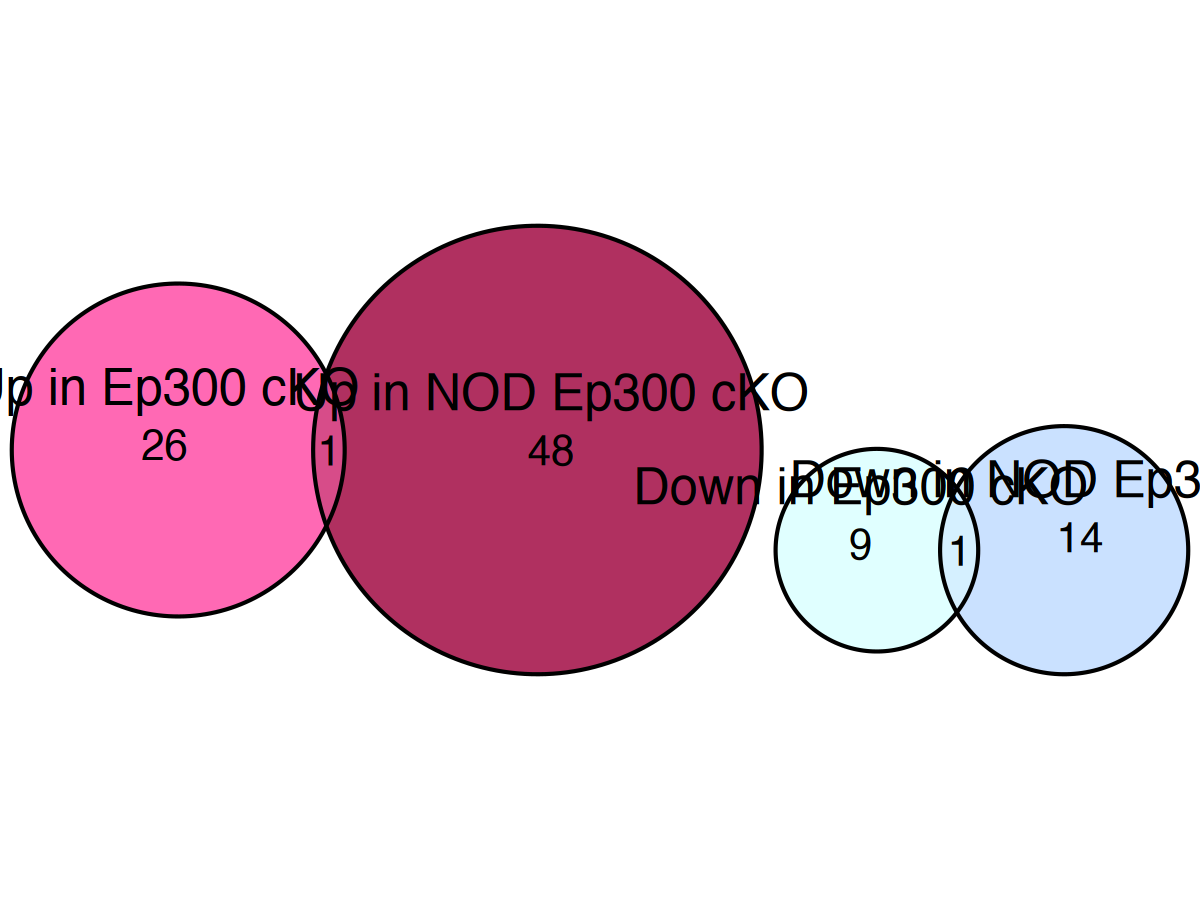

In [14]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 300)

image = plot(fit, quantities = FALSE, labels = FALSE, fill = c("hotpink", "lightcyan", 'maroon', 'lightsteelblue1'))

svglite("outputs/figures/figure2g.svg",width=4,height=3)
image
dev.off()

plot(fit, quantities = list(fontsize = 10), labels = list(fontsize = 12), fill = c("hotpink", "lightcyan", 'maroon', 'lightsteelblue1'))

Despite both experiments knocking out Ep300, we see only 1 gene is commonly decreased in both experiments, and only 1 gene is commonly increased in both experiments. 

Let's check what the common downregulated gene is.

In [15]:
intersect(ep300_ko_down, ep300_ko_NOD_down)

[1] "Plp1"

Let's check what the common upregulated gene is.

In [16]:
intersect(ep300_ko_up, ep300_ko_NOD_up)

[1] "Hif3a"

In [17]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggrastr_1.0.2 svglite_2.1.3 ggrepel_0.9.6 readxl_1.4.3  eulerr_7.0.2 
[6] ggpubr_0.6.0  dplyr_1.1.4   ggplot2_3.5.1

loaded via a namespace (and not attached):
 [1] generics_0.1.3    tidyr_1.3.1       rstatix_0.7.2     polylabelr_0.3.0 
 [5] digest_0.6.37     magrittr_2.0.3    evaluate_1.0.1    grid_4.3.3       
 [9] pbdZMQ_0.3-13     fastmap_1.2.0     cellranger_1.1.0  jsonlite_1.8.9   
[13] backports_1.5.0   Formula_1.2-5     purrr_1.0.2       scales_1.3.0     
[17] textshapi

In [18]:
version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             